In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
net = nn.Sequential(nn.Conv2d(1, 6, kernel_size=5, padding=2, stride=1), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2),
                    nn.Conv2d(6, 16, kernel_size=5, padding=0, stride=1), nn.Sigmoid(),
                    nn.AvgPool2d(kernel_size=2),
                    nn.Flatten(),
                    nn.Linear(16*5*5, 120), nn.Sigmoid(),
                    nn.Linear(120, 84), nn.Sigmoid(),
                    nn.Linear(84, 10))

In [3]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [4]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [5]:
def evaluate_accuracy_gpu(net, data_iter):
    net.eval()
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
            
def train_ch6(net, train_iter, test_iter, num_epochs, lr):    
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确的个数之和，样本数
        metric = d2l.Accumulator(3)
        
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
        train_l = metric[0] / metric[2]
        train_acc = metric[1] / metric[2]
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (train_l, train_acc, test_acc))
        
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, test acc {test_acc:.3f}')

loss 0.478, train acc 0.820, test acc 0.783


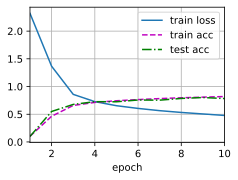

In [6]:
lr, num_epochs = 0.9, 10
net.apply(init_weights)
train_ch6(net, train_iter, test_iter, num_epochs, lr)

loss 0.399, train acc 0.854, test acc 0.822


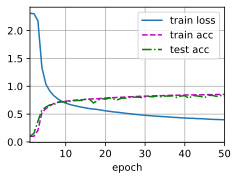

In [7]:
lr, num_epochs = 0.2, 50
net.apply(init_weights)
train_ch6(net, train_iter, test_iter, num_epochs, lr)